In [1]:
# 1. Environment Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_ind, f_oneway
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
import os
import sys
import time

warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

# Plotting style
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Seed
np.random.seed(42)
torch.manual_seed(42)

print("Env ready")

Env ready


In [2]:
# 2. Load Dataset and Explore Basic Information
# Load dataset
data_path = '../data/intent_dataset_20250830_121807.npz'
data = np.load(data_path, allow_pickle=True)

# Extract arrays
X_train = data['X_train']  # (n_trials, n_channels, n_samples)
X_val   = data['X_val']
X_test  = data['X_test']
y_train = data['y_train']
y_val   = data['y_val']
y_test  = data['y_test']

# Metadata
sampling_rate = int(data['sampling_rate'])
channel_names = data['channel_names'].tolist()
class_names   = data['class_names'].tolist()
label_map     = data['label_map'].item() if hasattr(data['label_map'], 'item') else data['label_map']

print("Dataset loaded")
print(f"Shapes | X_train{X_train.shape}  X_val{X_val.shape}  X_test{X_test.shape}")
print(f"Meta   | fs={sampling_rate}Hz  ch={len(channel_names)}  classes={class_names}")


Dataset loaded
Shapes | X_train(72, 6, 2500)  X_val(16, 6, 2500)  X_test(12, 6, 2500)
Meta   | fs=250Hz  ch=6  classes=['baseline', 'jaw_clench', 'gaze_left', 'gaze_right']


In [3]:
# 3. Data Preprocessing and Feature Extraction
from utils.preprocess import preprocess_batch
from utils.features import extract_features

# Preprocess
X_train_preprocessed = preprocess_batch(
    X_train, fs=sampling_rate, notch_freq=50, band=(1.0, 40.0), order=4, do_zscore=True
)
X_val_preprocessed = preprocess_batch(
    X_val, fs=sampling_rate, notch_freq=50, band=(1.0, 40.0), order=4, do_zscore=True
)
X_test_preprocessed = preprocess_batch(
    X_test, fs=sampling_rate, notch_freq=50, band=(1.0, 40.0), order=4, do_zscore=True
)
print("Preprocess: notch/bandpass/z-score done")

# Windowing
window_size = int(2.0 * sampling_rate)
hop_size    = int(1.0 * sampling_rate)

def segment_data(data, window_size, hop_size):
    # Segment trials into overlapping windows
    n_trials, n_channels, n_samples = data.shape
    windows = []
    for trial_idx in range(n_trials):
        trial = data[trial_idx]
        for start in range(0, n_samples - window_size + 1, hop_size):
            window = trial[:, start:start + window_size]
            windows.append(window)
    return np.array(windows)

X_train_windowed = segment_data(X_train_preprocessed, window_size, hop_size)
X_val_windowed   = segment_data(X_val_preprocessed, window_size, hop_size)
X_test_windowed  = segment_data(X_test_preprocessed, window_size, hop_size)

n_windows_per_trial = len(range(0, X_train.shape[-1] - window_size + 1, hop_size))
y_train_windowed = np.repeat(y_train, n_windows_per_trial)
y_val_windowed   = np.repeat(y_val,   n_windows_per_trial)
y_test_windowed  = np.repeat(y_test,  n_windows_per_trial)

print(f"Windowing: size={window_size} hop={hop_size} -> "
      f"Train{X_train_windowed.shape[0]}, Val{X_val_windowed.shape[0]}, Test{X_test_windowed.shape[0]}")

# Feature extraction
features = extract_features(
    X_train_windowed, X_val_windowed, X_test_windowed,
    fs=sampling_rate,
    bands=((4, 8), (8, 13), (13, 30)),
    make_images = True,
    channel_method='average'
)

X_time_train = features['X_time_train']
X_freq_train = features['X_freq_train']
X_time_val   = features['X_time_val']
X_freq_val   = features['X_freq_val']
X_time_test  = features['X_time_test']
X_freq_test  = features['X_freq_test']
X_img_train = features['X_img_train']
X_img_val   = features['X_img_val']
X_img_test  = features['X_img_test']
# Update labels
y_train = y_train_windowed
y_val   = y_val_windowed
y_test  = y_test_windowed

print("Feature extraction: time+bandpower done")
print(f"Features | time_train{X_time_train.shape}  freq_train{X_freq_train.shape}")

Preprocess: notch/bandpass/z-score done
Windowing: size=500 hop=250 -> Train648, Val144, Test108
Feature extraction: time+bandpower done
Features | time_train(648, 6, 500)  freq_train(648, 6, 3)


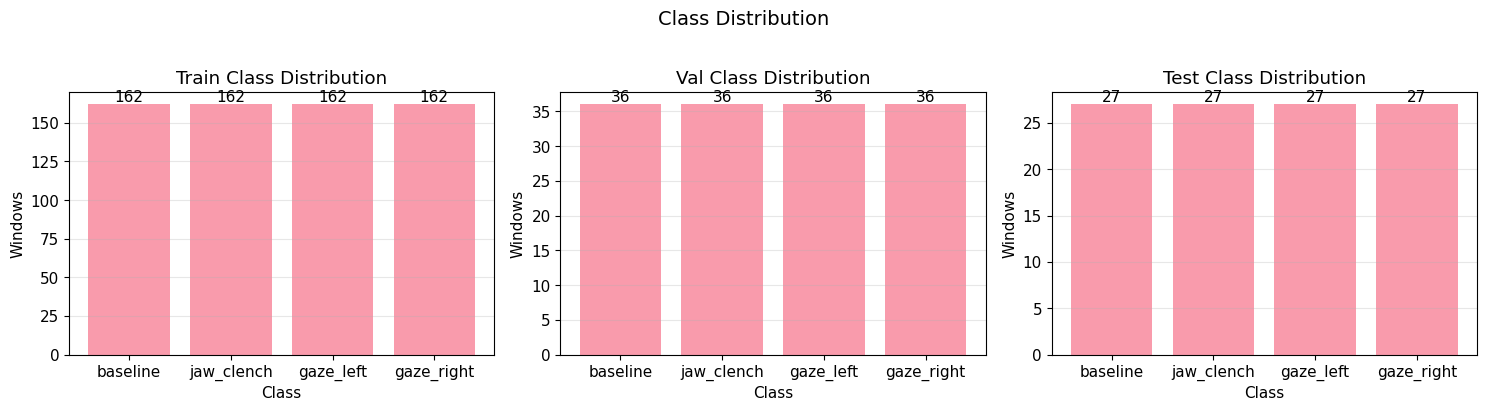

Class balance (%):
  Train baseline:25.0%, jaw_clench:25.0%, gaze_left:25.0%, gaze_right:25.0%
  Val   baseline:25.0%, jaw_clench:25.0%, gaze_left:25.0%, gaze_right:25.0%
  Test  baseline:25.0%, jaw_clench:25.0%, gaze_left:25.0%, gaze_right:25.0%


In [4]:
# 4. Class Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (y_data, title) in enumerate([(y_train, 'Train'), (y_val, 'Val'), (y_test, 'Test')]):
    unique, counts = np.unique(y_data, return_counts=True)
    axes[idx].bar([class_names[i] for i in unique], counts, alpha=0.7)
    axes[idx].set_title(f'{title} Class Distribution')
    axes[idx].set_xlabel('Class'); axes[idx].set_ylabel('Windows')
    axes[idx].grid(axis='y', alpha=0.3)
    for i, (u, c) in enumerate(zip(unique, counts)):
        axes[idx].text(i, c, str(c), ha='center', va='bottom')
plt.suptitle('Class Distribution', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

print("Class balance (%):")
for name, y_data in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    unique, counts = np.unique(y_data, return_counts=True)
    pct = (counts / counts.sum() * 100).round(1)
    pairs = ", ".join([f"{class_names[u]}:{p}%" for u, p in zip(unique, pct)])
    print(f"  {name:<5} {pairs}")

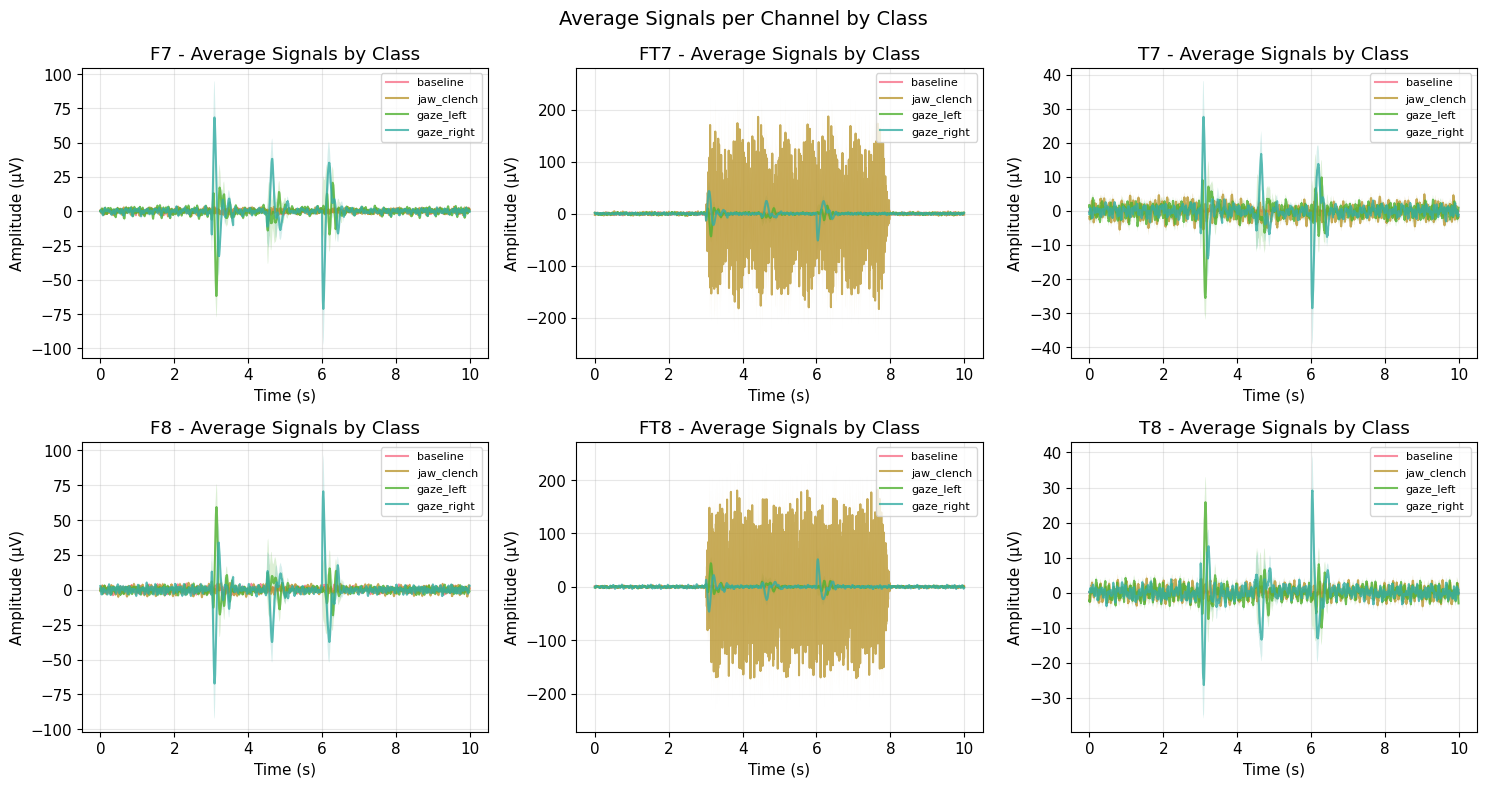


Channel stats (Train):
Channel    Mean±SD (μV)         Min          Max          SNR(dB)   
F7            0.04±18.48       -293.41      329.62      0.00
FT7          -0.00±94.93      -1069.94     1115.57      0.00
T7           -0.08±8.98        -120.15      136.62      0.00
F8            0.06±18.43       -323.52      297.78      0.00
FT8           0.07±97.37      -1086.66     1120.43      0.00
T8            0.05±8.84        -123.04      120.66      0.00


In [5]:
# 5. Signal Quality Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ch_idx, ch_name in enumerate(channel_names):
    ax = axes[ch_idx // 3, ch_idx % 3]
    for class_idx, class_name in enumerate(class_names):
        class_mask    = data['y_train'] == class_idx
        class_signals = data['X_train'][class_mask, ch_idx, :]
        mean_signal   = np.mean(class_signals, axis=0)
        std_signal    = np.std(class_signals, axis=0) / np.sqrt(len(class_signals))
        time_axis     = np.arange(len(mean_signal)) / sampling_rate
        ax.plot(time_axis, mean_signal, label=class_name, alpha=0.8)
        ax.fill_between(time_axis, mean_signal - std_signal, mean_signal + std_signal, alpha=0.2)
    ax.set_title(f'{ch_name} - Average Signals by Class')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('Amplitude (μV)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
plt.suptitle('Average Signals per Channel by Class', fontsize=14)
plt.tight_layout(); plt.show()

print("\nChannel stats (Train):")
print(f"{'Channel':<10} {'Mean±SD (μV)':<20} {'Min':<12} {'Max':<12} {'SNR(dB)':<10}")
for ch_idx, ch_name in enumerate(channel_names):
    ch_data   = data['X_train'][:, ch_idx, :].flatten()
    mean_val  = np.mean(ch_data)
    std_val   = np.std(ch_data)
    min_val   = np.min(ch_data)
    max_val   = np.max(ch_data)
    signal_p  = np.mean(ch_data**2)
    noise_p   = np.var(ch_data)
    snr       = 10 * np.log10(signal_p / noise_p) if noise_p > 0 else 0
    print(f"{ch_name:<10} {mean_val:>7.2f}±{std_val:<7.2f} {min_val:>11.2f} {max_val:>11.2f} {snr:>9.2f}")

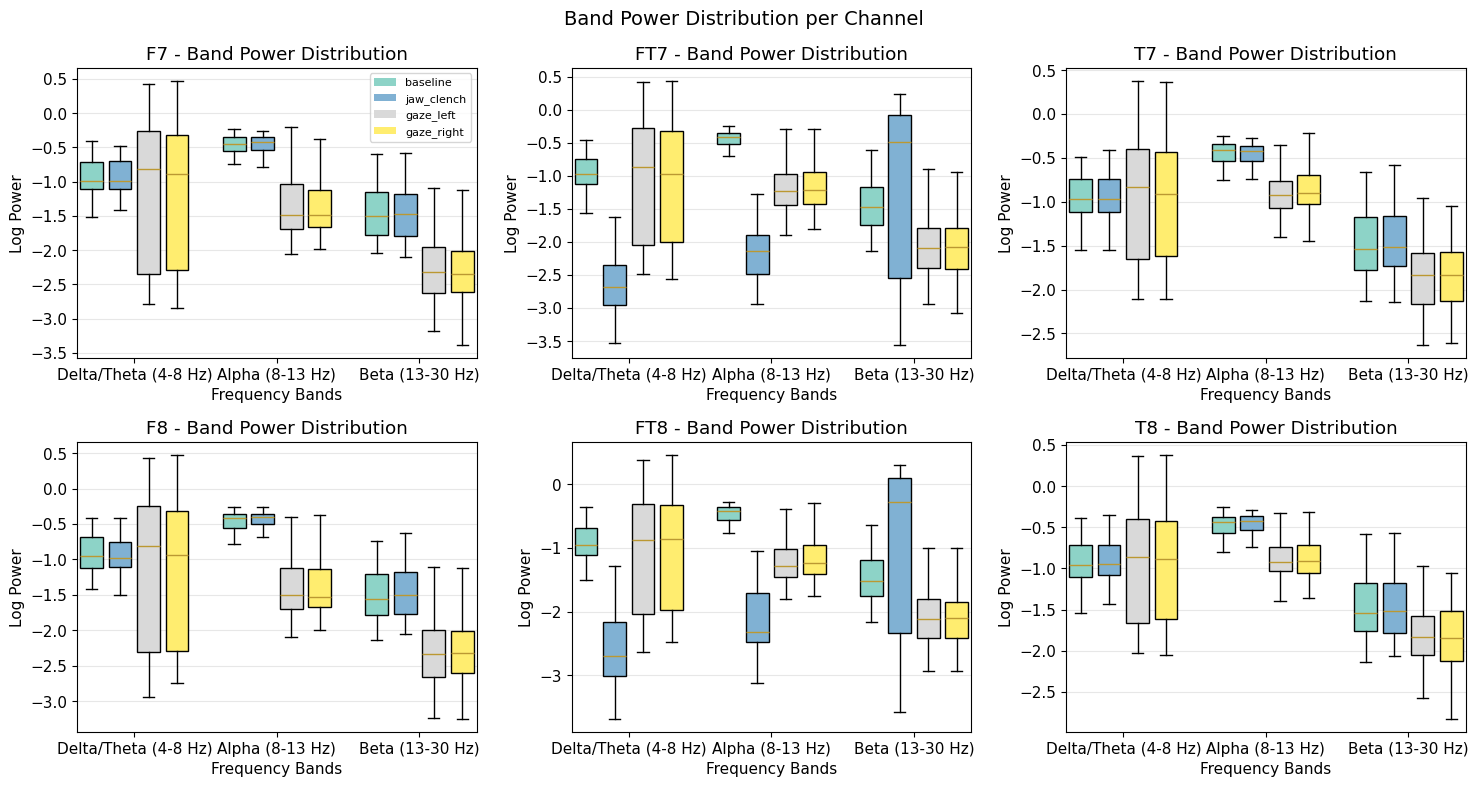


Band-power ANOVA p-values (p<0.05 indicates significance)
Channel    Delta/Theta     Alpha           Beta           
F7         0.0000          0.0000          0.0000         
FT7        0.0000          0.0000          0.0000         
T7         0.7636          0.0000          0.0000         
F8         0.0000          0.0000          0.0000         
FT8        0.0000          0.0000          0.0000         
T8         0.3956          0.0000          0.0000         


In [6]:
# 6. Frequency Domain Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
band_names = ['Delta/Theta (4-8 Hz)', 'Alpha (8-13 Hz)', 'Beta (13-30 Hz)']
for ch_idx, ch_name in enumerate(channel_names):
    ax = axes[ch_idx // 3, ch_idx % 3]
    band_powers = []
    for class_idx in range(len(class_names)):
        class_mask = y_train == class_idx
        class_freq = X_freq_train[class_mask, ch_idx, :]
        band_powers.append(class_freq)
    for band_idx in range(3):
        band_positions = [band_idx * 5 + i for i in range(len(class_names))]
        band_data = [band_powers[i][:, band_idx] for i in range(len(class_names))]
        bp = ax.boxplot(band_data, positions=band_positions, widths=0.8,
                        patch_artist=True, showfliers=False)
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
    ax.set_title(f'{ch_name} - Band Power Distribution')
    ax.set_xlabel('Frequency Bands'); ax.set_ylabel('Log Power')
    ax.set_xticks([1.5, 6.5, 11.5]); ax.set_xticklabels(band_names)
    ax.grid(True, alpha=0.3, axis='y')
    if ch_idx == 0:
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=plt.cm.Set3(i/3), label=class_names[i]) 
                           for i in range(len(class_names))]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
plt.suptitle('Band Power Distribution per Channel', fontsize=14)
plt.tight_layout(); plt.show()

print("\nBand-power ANOVA p-values (p<0.05 indicates significance)")
print(f"{'Channel':<10} {'Delta/Theta':<15} {'Alpha':<15} {'Beta':<15}")
for ch_idx, ch_name in enumerate(channel_names):
    p_values = []
    for band_idx in range(3):
        groups = [X_freq_train[y_train == i, ch_idx, band_idx] for i in range(len(class_names))]
        _, p_val = f_oneway(*groups)
        p_values.append(p_val)
    print(f"{ch_name:<10} {p_values[0]:<15.4f} {p_values[1]:<15.4f} {p_values[2]:<15.4f}")

PCA/t-SNE running ...


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte


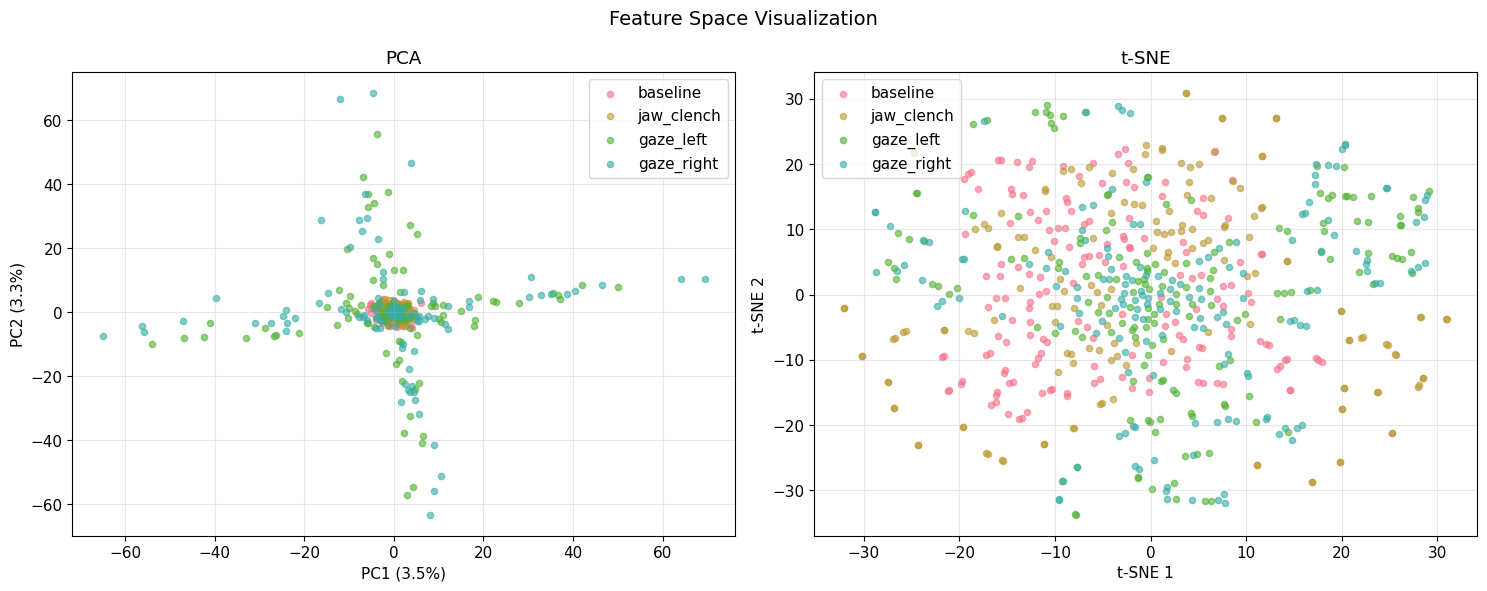

PCA: 10 comps=24.5%, 50 comps=65.6%, 90% at 1 comps


In [7]:
# 7. Feature Visualization (PCA & t-SNE)
X_combined_train = np.concatenate([
    X_time_train.reshape(X_time_train.shape[0], -1),
    X_freq_train.reshape(X_freq_train.shape[0], -1)
], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined_train)

print("PCA/t-SNE running ...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

n_samples_tsne = min(1000, len(X_scaled))
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca[:n_samples_tsne])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
for class_idx, class_name in enumerate(class_names):
    mask = y_train[:len(X_pca)] == class_idx
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=class_name, alpha=0.6, s=20)
ax.set_title('PCA'); ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)'); ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1]
for class_idx, class_name in enumerate(class_names):
    mask = y_train[:n_samples_tsne] == class_idx
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=class_name, alpha=0.6, s=20)
ax.set_title('t-SNE'); ax.set_xlabel('t-SNE 1'); ax.set_ylabel('t-SNE 2')
ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle('Feature Space Visualization', fontsize=14)
plt.tight_layout(); plt.show()

cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
print(f"PCA: 10 comps={cumsum_var[9]*100:.1f}%, 50 comps={cumsum_var[49]*100:.1f}%, 90% at {n_components_90} comps")


In [8]:
# 8. Deep Learning Model Training
from models.multimodal_model import MultiModalNet
from collections import Counter

n_channels = 6
n_samples  = window_size
n_bands    = 3
hidden_dim = 64
img_out_dim= 64
n_classes  = len(class_names)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalNet(
    n_channels=n_channels,
    n_samples=n_samples,
    n_bands=n_bands,
    img_out_dim=img_out_dim,
    hidden_dim=hidden_dim,
    n_classes=n_classes,
    use_img=True
).to(device)

batch_size = 16
train_dataset = TensorDataset(
    torch.FloatTensor(X_time_train),
    torch.FloatTensor(X_freq_train),
    torch.FloatTensor(X_img_train),        
    torch.LongTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_time_val),
    torch.FloatTensor(X_freq_val),
    torch.FloatTensor(X_img_val),     
    torch.LongTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_time_test),
    torch.FloatTensor(X_freq_test),
    torch.FloatTensor(X_img_test),    
    torch.LongTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

cnt = Counter(y_train.tolist())
cls_w = torch.tensor([1.0 / max(cnt.get(i, 1), 1) for i in range(len(class_names))],
                     dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=cls_w, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f"Device: {device}")
print(f"Params: total={sum(p.numel() for p in model.parameters()):,} "
      f"trainable={sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Device: cuda
Params: total=11,270,724 trainable=11,270,724


Training ...
Epoch 10/50 | Train 0.5160/0.8997 | Val 0.7445/0.7431
Epoch 20/50 | Train 0.4345/0.9660 | Val 0.8915/0.6875
Epoch 30/50 | Train 0.3791/0.9923 | Val 0.9640/0.7153
Epoch 40/50 | Train 0.3701/0.9969 | Val 0.9639/0.7569
Epoch 50/50 | Train 0.3668/0.9969 | Val 0.9481/0.7778


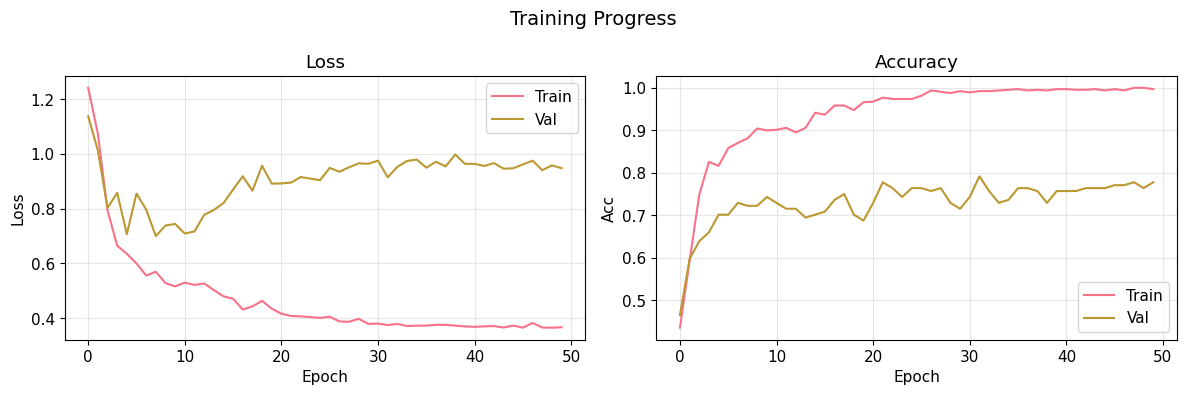

Train done
Best val acc: 0.7917 @ epoch 32
Model saved: ../best_intent_model.pth


In [9]:
# 9. Model Training Process
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch in loader:
        if len(batch) == 3:
            x_time, x_freq, y = batch
            x_img = None
        else:
            x_time, x_freq, x_img, y = batch

        x_time = x_time.to(device, non_blocking=True)
        x_freq = x_freq.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)
        if x_img is not None:
            x_img = x_img.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(x_time, x_freq) if x_img is None else model(x_time, x_freq, x_img)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                x_time, x_freq, y = batch
                x_img = None
            else:
                x_time, x_freq, x_img, y = batch

            x_time = x_time.to(device, non_blocking=True)
            x_freq = x_freq.to(device, non_blocking=True)
            y     = y.to(device, non_blocking=True)
            if x_img is not None:
                x_img = x_img.to(device, non_blocking=True)

            outputs = model(x_time, x_freq) if x_img is None else model(x_time, x_freq, x_img)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
    return total_loss / len(loader), correct / total

epochs = 50
train_losses, train_accs, val_losses, val_accs = [], [], [], []

print("Training ...")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss);     val_accs.append(val_acc)
    scheduler.step(val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:02d}/{epochs} | Train {train_loss:.4f}/{train_acc:.4f} | Val {val_loss:.4f}/{val_acc:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train'); axes[0].plot(val_losses, label='Val')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(train_accs, label='Train'); axes[1].plot(val_accs, label='Val')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Acc');  axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.suptitle('Training Progress', fontsize=14); plt.tight_layout(); plt.show()

print("Train done")
print(f"Best val acc: {max(val_accs):.4f} @ epoch {np.argmax(val_accs)+1}")

model_save_path = '../best_intent_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved: {model_save_path}")

Test | loss=0.8205 acc=0.8056


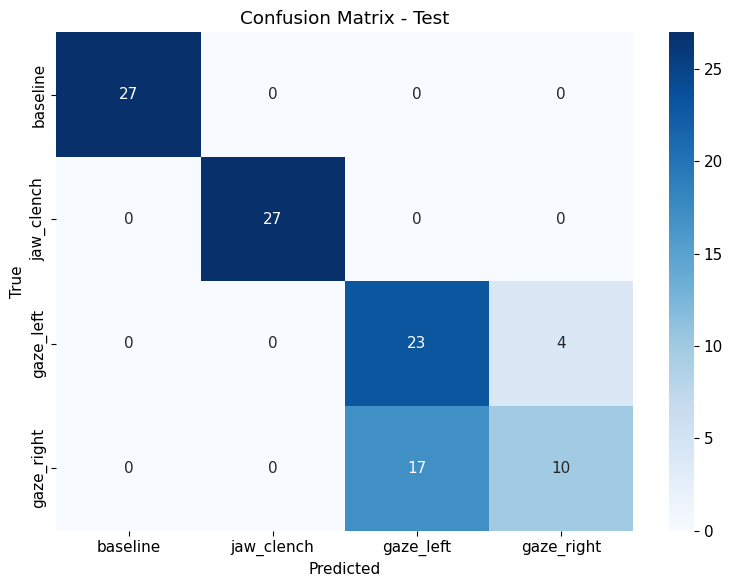


Classification report:
              precision    recall  f1-score   support

    baseline     1.0000    1.0000    1.0000        27
  jaw_clench     1.0000    1.0000    1.0000        27
   gaze_left     0.5750    0.8519    0.6866        27
  gaze_right     0.7143    0.3704    0.4878        27

    accuracy                         0.8056       108
   macro avg     0.8223    0.8056    0.7936       108
weighted avg     0.8223    0.8056    0.7936       108



In [10]:
# 10. Model Evaluation
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test | loss={test_loss:.4f} acc={test_acc:.4f}")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        if len(batch) == 3:
            x_time, x_freq, y = batch
            x_img = None
        else:
            x_time, x_freq, x_img, y = batch

        x_time = x_time.to(device)
        x_freq = x_freq.to(device)
        if x_img is not None: x_img = x_img.to(device)

        out = model(x_time, x_freq) if x_img is None else model(x_time, x_freq, x_img)
        _, pred = out.max(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.numpy())
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title('Confusion Matrix - Test')
plt.tight_layout(); plt.show()

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

In [11]:
# === Extra metrics ===
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score

N = len(class_names)
y_true = all_labels
y_pred = all_preds

# macro-F1
macro_f1 = f1_score(y_true, y_pred, average='macro',
                    labels=list(range(N)), zero_division=0)

# Cohen's kappa
kappa = cohen_kappa_score(y_true, y_pred, labels=list(range(N)))

# balanced accuracy (optional)
bacc = balanced_accuracy_score(y_true, y_pred)

# ITR (bits/trial & bits/min)
def itr_bits_per_trial(N, P):
    eps = 1e-12
    P = np.clip(P, eps, 1 - eps)
    return np.log2(N) + P*np.log2(P) + (1-P)*np.log2((1-P)/(N-1))

P_acc = accuracy_score(y_true, y_pred)
# decision period: if you输出每个hop一次决策 -> 用 hop_size；若每个窗口一次 -> 用 window_size
T_decision = hop_size / sampling_rate    # seconds per decision
# T_decision = window_size / sampling_rate  # use this line if one decision per window

itr_bpt = itr_bits_per_trial(N, P_acc)
itr_bpm = itr_bpt * 60.0 / T_decision

print(f"Extra metrics | acc={P_acc:.4f}  macro-F1={macro_f1:.4f}  kappa={kappa:.4f}  "
      f"bAcc={bacc:.4f}  ITR={itr_bpt:.3f} bits/trial, {itr_bpm:.1f} bits/min (T={T_decision:.1f}s)")

Extra metrics | acc=0.8056  macro-F1=0.7936  kappa=0.7407  bAcc=0.8056  ITR=0.981 bits/trial, 58.9 bits/min (T=1.0s)


In [12]:
# 11. Error Analysis
misclassified     = all_preds != all_labels
misclass_indices  = np.where(misclassified)[0]
print(f"Errors: {len(misclass_indices)}/{len(all_labels)} ({len(misclass_indices)/len(all_labels)*100:.1f}%)")
print("\nTop mislabels:")
print(f"{'True':<15} {'Pred':<15} {'Count':<5}")

error_matrix = np.zeros((len(class_names), len(class_names)))
for idx in misclass_indices:
    t, p = all_labels[idx], all_preds[idx]
    error_matrix[t, p] += 1
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and error_matrix[i, j] > 0:
            print(f"{class_names[i]:<15} {class_names[j]:<15} {int(error_matrix[i, j]):<5}")

Errors: 21/108 (19.4%)

Top mislabels:
True            Pred            Count
gaze_left       gaze_right      4    
gaze_right      gaze_left       17   


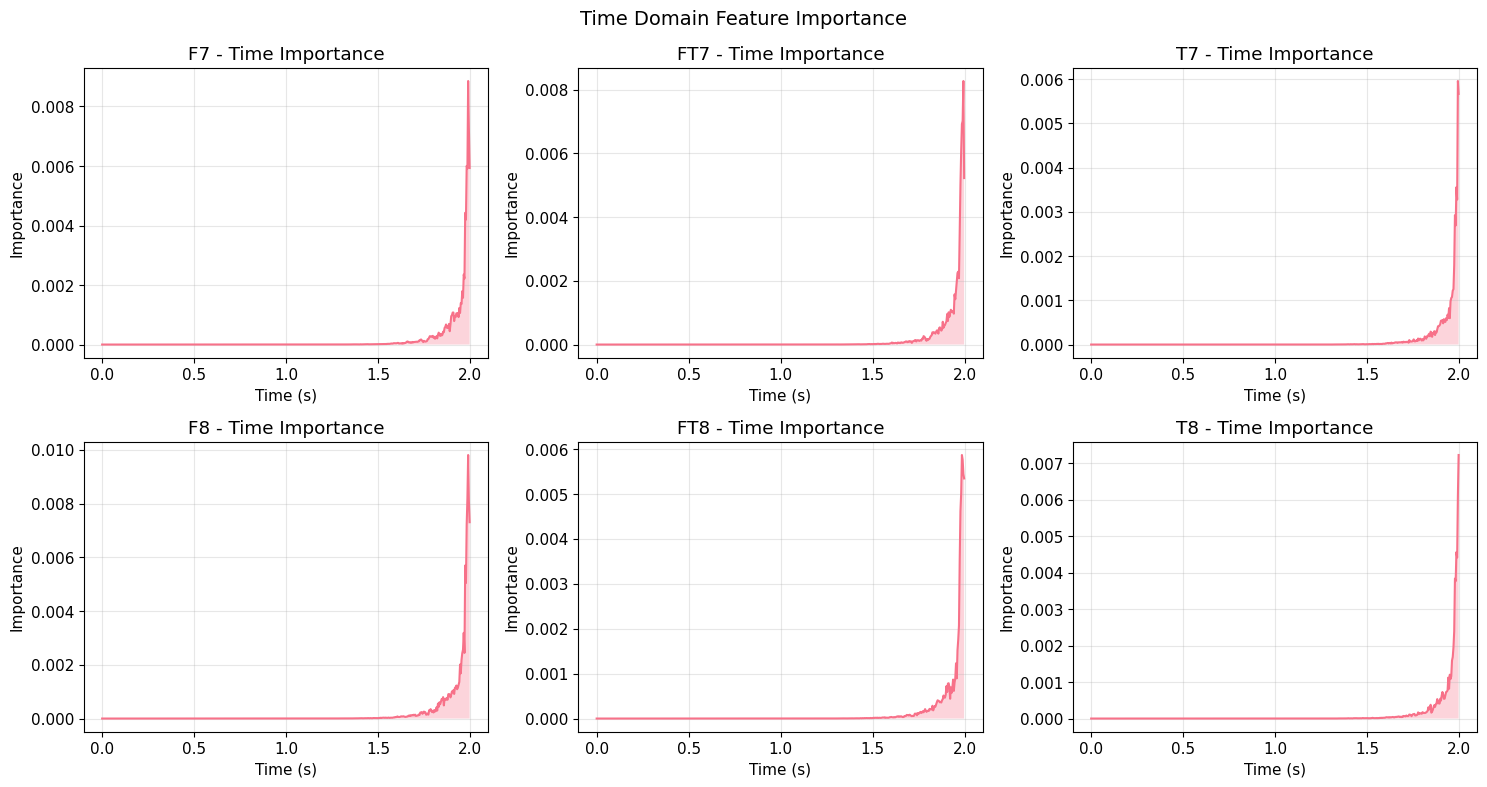

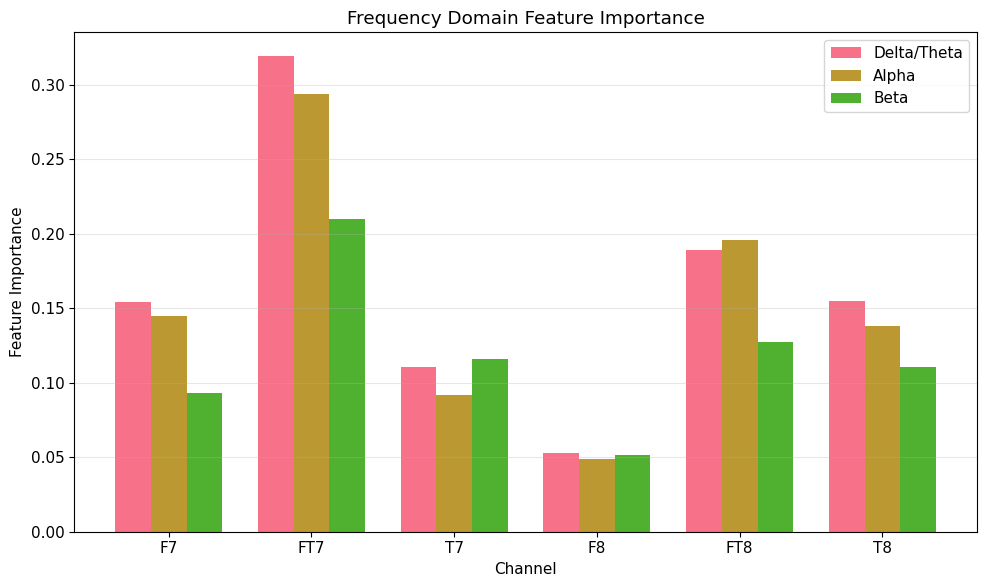

In [13]:
# 12. Feature Importance Analysis
model.train()
feature_importance_time = np.zeros((6, X_time_test.shape[-1]))
feature_importance_freq = np.zeros((6, 3))

correct_mask   = all_preds == all_labels
correct_indices= np.where(correct_mask)[0][:50]

for idx in correct_indices:
    x_time = torch.FloatTensor(X_time_test[idx:idx+1]).to(device).requires_grad_(True)
    x_freq = torch.FloatTensor(X_freq_test[idx:idx+1]).to(device).requires_grad_(True)
    x_img  = torch.FloatTensor(X_img_test[idx:idx+1]).to(device).requires_grad_(True)
    output = model(x_time, x_freq, x_img)
    output[0, all_labels[idx]].backward()
    feature_importance_time += np.abs(x_time.grad.cpu().numpy()[0])
    feature_importance_freq += np.abs(x_freq.grad.cpu().numpy()[0])

feature_importance_time /= len(correct_indices)
feature_importance_freq /= len(correct_indices)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
time_axis = np.arange(X_time_test.shape[-1]) / sampling_rate
for ch_idx, ch_name in enumerate(channel_names):
    ax = axes[ch_idx // 3, ch_idx % 3]
    ax.plot(time_axis, feature_importance_time[ch_idx], linewidth=1.5)
    ax.set_title(f'{ch_name} - Time Importance')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('Importance')
    ax.grid(True, alpha=0.3); ax.fill_between(time_axis, 0, feature_importance_time[ch_idx], alpha=0.3)
plt.suptitle('Time Domain Feature Importance', fontsize=14)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(channel_names)); width = 0.25
for band_idx, band_name in enumerate(['Delta/Theta', 'Alpha', 'Beta']):
    values = feature_importance_freq[:, band_idx]
    ax.bar(x_pos + band_idx * width, values, width, label=band_name)
ax.set_xlabel('Channel'); ax.set_ylabel('Feature Importance'); ax.set_title('Frequency Domain Feature Importance')
ax.set_xticks(x_pos + width); ax.set_xticklabels(channel_names)
ax.legend(); ax.grid(True, alpha=0.3, axis='y'); plt.tight_layout(); plt.show()


RT perf:
  infer=3.42±3.25 ms (min=0.00, max=12.90) | rate≈292.7 Hz | win=2.0s | RTF=585.5x


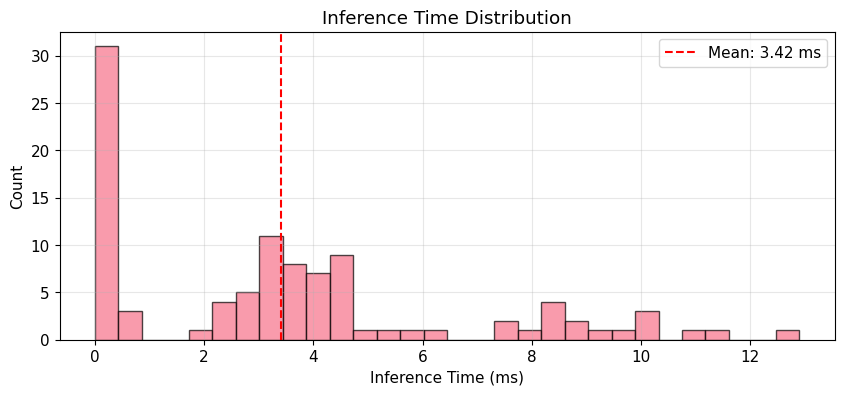

In [14]:
# 13. Real-time Performance Evaluation
model.eval()
inference_times = []
with torch.no_grad():
    for _ in range(100):
        x_time = torch.FloatTensor(X_time_test[0:1]).to(device)
        x_freq = torch.FloatTensor(X_freq_test[0:1]).to(device)
        x_img  = torch.FloatTensor(X_img_test[0:1]).to(device)
        t0 = time.time()
        _ = model(x_time, x_freq, x_img)
        inference_times.append((time.time() - t0) * 1000)

avg_infer = np.mean(inference_times); std_infer = np.std(inference_times)
print("RT perf:")
print(f"  infer={avg_infer:.2f}±{std_infer:.2f} ms "
      f"(min={np.min(inference_times):.2f}, max={np.max(inference_times):.2f}) | "
      f"rate≈{1000/avg_infer:.1f} Hz | "
      f"win={X_time_test.shape[-1]/sampling_rate:.1f}s | "
      f"RTF={(X_time_test.shape[-1]/sampling_rate*1000)/avg_infer:.1f}x")

plt.figure(figsize=(10, 4))
plt.hist(inference_times, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(avg_infer, color='red', linestyle='--', label=f'Mean: {avg_infer:.2f} ms')
plt.xlabel('Inference Time (ms)'); plt.ylabel('Count'); plt.title('Inference Time Distribution')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

  time=0.6759
  freq=0.7500
  img=0.4537
  multi=0.8056
  Time-only: acc=0.8056  macro-F1=0.7936  bAcc=0.8056


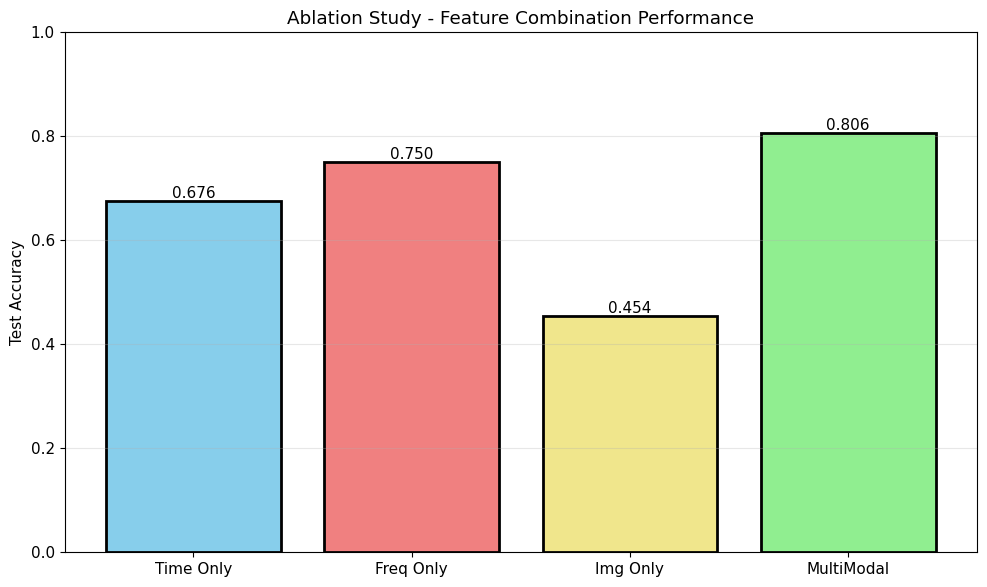

Δ multi-time = 13.0% | Δ multi-freq = 5.6%


In [ ]:
# 14. Ablation Study
class TimeOnlyModel(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        from models.branches import TimeBranch
        self.time_branch = TimeBranch(n_channels, n_samples, hidden_dim)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x_time):
        feats = self.time_branch(x_time)
        return self.fc(feats)

class FreqOnlyModel(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        from models.branches import FreqBranch
        self.freq_branch = FreqBranch(n_channels, n_bands, hidden_dim)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x_freq):
        feats = self.freq_branch(x_freq)
        return self.fc(feats)
    
class ImgOnlyModel(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        from models.branches import ImgBranch
        self.img_branch = ImgBranch(img_out_dim)  # assumes 1xHxW input -> img_out_dim
        self.fc = nn.Linear(img_out_dim, n_classes)
    def forward(self, x_img):
        feats = self.img_branch(x_img)
        return self.fc(feats)
    
ablation_results = {}

# Time-only
time_model = TimeOnlyModel(len(class_names)).to(device)
time_opt   = optim.Adam(time_model.parameters(), lr=1e-3)
for epoch in range(20):
    time_model.train()
    for x_time, x_freq, x_img, y in train_loader:
        x_time, y = x_time.to(device), y.to(device)
        time_opt.zero_grad()
        logits = time_model(x_time)
        loss   = criterion(logits, y)
        loss.backward()
        time_opt.step()
time_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x_time, x_freq, x_img, y in test_loader:
        x_time, y = x_time.to(device), y.to(device)
        pred = time_model(x_time).argmax(1)
        total += y.size(0); correct += (pred == y).sum().item()
ablation_results['Time Only'] = correct / total
print(f"  time={ablation_results['Time Only']:.4f}")

# Freq-only
freq_model = FreqOnlyModel(len(class_names)).to(device)
freq_opt   = optim.Adam(freq_model.parameters(), lr=1e-3)  # fixed from config.learning_rate
for epoch in range(20):
    freq_model.train()
    for x_time, x_freq, x_img, y in train_loader:
        x_freq, y = x_freq.to(device), y.to(device)
        freq_opt.zero_grad()
        logits = freq_model(x_freq)
        loss   = criterion(logits, y)
        loss.backward()
        freq_opt.step()
freq_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x_time, x_freq, x_img, y in test_loader:
        x_freq, y = x_freq.to(device), y.to(device)
        pred = freq_model(x_freq).argmax(1)
        total += y.size(0); correct += (pred == y).sum().item()
ablation_results['Freq Only'] = correct / total
print(f"  freq={ablation_results['Freq Only']:.4f}")

# Img-only
img_model = ImgOnlyModel(len(class_names)).to(device)
img_opt   = optim.Adam(img_model.parameters(), lr=1e-3)
for epoch in range(20):
    img_model.train()
    for x_time, x_freq, x_img, y in train_loader:  # requires x_img in loader
        x_img, y = x_img.to(device), y.to(device)
        img_opt.zero_grad()
        logits = img_model(x_img)
        loss   = criterion(logits, y)
        loss.backward()
        img_opt.step()
img_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x_time, x_freq, x_img, y in test_loader:
        x_img, y = x_img.to(device), y.to(device)
        pred = img_model(x_img).argmax(1)
        total += y.size(0); correct += (pred == y).sum().item()
ablation_results['Img Only'] = correct / total
print(f"  img={ablation_results['Img Only']:.4f}")

# MultiModal uses test_acc directly
ablation_results['MultiModal'] = test_acc
print(f"  multi={ablation_results['MultiModal']:.4f}")

plt.figure(figsize=(10, 6))
models = list(ablation_results.keys())
accuracies = list(ablation_results.values())
colors = ['skyblue', 'lightcoral', 'khaki', 'lightgreen'][:len(models)]
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
plt.ylabel('Test Accuracy'); plt.title('Ablation Study - Feature Combination Performance')
plt.ylim([0, 1]); plt.grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars, accuracies):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h, f'{acc:.3f}', ha='center', va='bottom', fontsize=11)
plt.tight_layout(); plt.show()

print(f"Δ multi-time = {(ablation_results['MultiModal']-ablation_results['Time Only'])*100:.1f}% | "
      f"Δ multi-freq = {(ablation_results['MultiModal']-ablation_results['Freq Only'])*100:.1f}%")

In [16]:
# 15. Cross-validation Analysis
from sklearn.model_selection import KFold

X_time_all = np.concatenate([X_time_train, X_time_val, X_time_test])
X_freq_all = np.concatenate([X_freq_train, X_freq_val, X_freq_test])
y_all      = np.concatenate([y_train, y_val, y_test])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

print("CV (5-fold) ...")
for fold, (tr_idx, te_idx) in enumerate(kf.split(X_time_all), 1):
    cv_model = MultiModalNet(
        n_channels=n_channels, n_samples=n_samples, n_bands=n_bands,
        img_out_dim=img_out_dim, hidden_dim=hidden_dim, n_classes=n_classes, use_img=False
    ).to(device)
    cv_opt = optim.Adam(cv_model.parameters(), lr=1e-3)
    cv_train_ds = TensorDataset(torch.FloatTensor(X_time_all[tr_idx]),
                                torch.FloatTensor(X_freq_all[tr_idx]),
                                torch.LongTensor(y_all[tr_idx]))
    cv_test_ds  = TensorDataset(torch.FloatTensor(X_time_all[te_idx]),
                                torch.FloatTensor(X_freq_all[te_idx]),
                                torch.LongTensor(y_all[te_idx])) 
    # fix typo
    cv_test_ds  = TensorDataset(torch.FloatTensor(X_time_all[te_idx]),
                                torch.FloatTensor(X_freq_all[te_idx]),
                                torch.LongTensor(y_all[te_idx]))
    cv_train_ld = DataLoader(cv_train_ds, batch_size=batch_size, shuffle=True)
    cv_test_ld  = DataLoader(cv_test_ds,  batch_size=batch_size, shuffle=False)
    for _ in range(15):
        train_epoch(cv_model, cv_train_ld, criterion, cv_opt, device)
    _, acc = validate(cv_model, cv_test_ld, criterion, device)
    cv_scores.append(acc)

print("\nCV (5-fold): "
      f"mean={np.mean(cv_scores):.4f}±{np.std(cv_scores):.4f} | "
      f"best={np.max(cv_scores):.4f} | worst={np.min(cv_scores):.4f}")

CV (5-fold) ...

CV (5-fold): mean=0.8367±0.0282 | best=0.8667 | worst=0.7833


In [19]:
# 16. Summary Report
print("\n=== SUMMARY ===")
print(f"Data  | windows={len(X_time_all)}  trials={len(data['X_train'])+len(data['X_val'])+len(data['X_test'])}  "
      f"classes={len(class_names)}  fs={sampling_rate}Hz  win=2.0s  ch={len(channel_names)}")
print(f"Perf  | test={test_acc:.2%}  cv={np.mean(cv_scores):.2%}±{np.std(cv_scores):.2%}  "
      f"best_val={max(val_accs):.2%}")
for i, cname in enumerate(class_names):
    m = all_labels == i
    if m.sum() > 0:
        print(f"Class | {cname:<12} acc={(all_preds[m]==all_labels[m]).mean():.2%}")
print(f"RT    | infer={avg_infer:.2f}ms  RTF={(X_time_test.shape[-1]/sampling_rate*1000)/avg_infer:.1f}x")
print(f"Abl   | time={ablation_results['Time Only']:.2%}  "
      f"freq={ablation_results['Freq Only']:.2%}  multi={ablation_results['MultiModal']:.2%}")
print(f"Metrics | macro-F1={macro_f1:.4f}  kappa={kappa:.4f}  "
      f"bAcc={bacc:.4f}  ITR={itr_bpt:.3f} bits/trial, {itr_bpm:.1f} bits/min")
print("Tips  | collect more data; try attention; consider online adaptation")


=== SUMMARY ===
Data  | windows=900  trials=100  classes=4  fs=250Hz  win=2.0s  ch=6
Perf  | test=80.56%  cv=83.67%±2.82%  best_val=79.17%
Class | baseline     acc=100.00%
Class | jaw_clench   acc=100.00%
Class | gaze_left    acc=85.19%
Class | gaze_right   acc=37.04%
RT    | infer=3.42ms  RTF=585.5x
Abl   | time=67.59%  freq=75.00%  multi=80.56%
Metrics | macro-F1=0.7936  kappa=0.7407  bAcc=0.8056  ITR=0.981 bits/trial, 58.9 bits/min
Tips  | collect more data; try attention; consider online adaptation
